# PHT EB Candidates - Comparison with TESS EB

[TESS EB Catalog](http://tessebs.villanova.edu/) uses PHT #eclipsingbinary tagging as one of the input sources.

In [1]:
from importlib import reload

from IPython.display import display, HTML, clear_output

import numpy as np

import pandas as pd
from pandas.io.clipboard import clipboard_set

import matplotlib.pyplot as plt

import catalog_stats
import dashboard_utils
import vetting_meta
from dashboard_utils import CAT_COLS_COMMON

display(HTML("<style>.container { width:99% !important; }</style>"))

- To compare with the result from  the published [TESS EB catalog](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...16P/abstract), covering sectors 1 - 26, we use a subset of PHT EB Catalog that has comparable coverage.
- Furthermore, we only consider the subset that has decent accuracy (`eb_score >= 3`)

In [2]:
reload(dashboard_utils)

df_catplus = dashboard_utils.join_pht_eb_candidate_catalog_with(["tesseb"])

# Include only those with observations in sectors 1-26
df_catplus = df_catplus[df_catplus["min_sector"] <= 26]

min_eb_score = 3
res, report, styler = catalog_stats.estimate_num_ebs_not_in_catalog(df_catplus, min_eb_score=min_eb_score);
display(report)

df_subset = df_catplus[df_catplus["eb_score_group"] == "03+"]
display(HTML(f"""
Num. of TICs with decent accuracy with observations in sectors 1-26:
<span style="font-weight:bold; font-family: monospace; background-color: yellow;"> {len(df_subset)} </span>
"""))

count                            
               tic_id                            
is_eb_catalog       T    F     - Totals   T/(T+F)
eb_score_group                                   
03+              1825  118   895   2838  0.939269
02-              1287  880  3829   5996  0.593909
Totals           3112  998  4724   8834  0.757178

### Those in PHT EB but not in TESS EB

- are they false positives in PHT EB, or could it be that TESS EB miss those targets?
  - TESS EB does miss a noticeable portion of them:
  - 246 of them have been classified as EB in SIMBAD, VSX or ASAS-SN 
- If TESS EB miss those targets, are there some (systematic) reasons?

In [3]:
report = df_subset.pivot_table(
    index=["TESSEB_Is_In"],
    columns="is_eb_catalog",
    values=["tic_id"],
    aggfunc=["count"],
    margins=True,
    margins_name="Totals",
)

report

count                  
              tic_id                  
is_eb_catalog      -    F     T Totals
TESSEB_Is_In                          
F                187   43   269    499
T                708   75  1556   2339
Totals           895  118  1825   2838

- 499 out of 2838 TICs are not in TESS EB. Out of 438
    - 269 of them are already classified as EB in SIMBAD , VSX or ASAS-SN.
    - 230 (187 + 43) of them remain uncertain, and require further triage

### Triage  samples

23 TICs with short cadence data in sectors 1-26 are inspected. Main findings:
- TESS EB false positives due to NEB
- TESS EB eclipse duration accuracy


Note: The false positives / false negative rates reported below are likely to be much higher than the real values, because the samples are biased: they do not include known EBs in VSX, ASAS-SN, or SIMBAD

In [4]:
df_vetting_statuses = vetting_meta.load_vetting_statuses_table(add_disposition_group=True, add_tesseb_url_col=True, add_vetting_doc_url_col=True)

df = df_vetting_statuses

df = df[df["In TESSEBs1-26"] != "NA"]  # only those with observations in sectors 1 - 26


pivot = df.pivot_table(
    index=["Disposition_Group"],
    columns=["In TESSEBs1-26"],
    values=["TIC"],
    aggfunc=["count"],
    fill_value=0,  # convert NaN count result to zero
)
display(pivot)

print("Num. in Sectors 1 - 26:", len(df))

num_in_tesseb_vetted = pivot.loc["Candidate", ("count", "TIC", "Y")]
num_in_tesseb_fp = pivot.loc["FP", ("count", "TIC", "Y")]
pct_fp = 100 * num_in_tesseb_fp / (num_in_tesseb_fp + num_in_tesseb_vetted)

num_not_in_tesseb_vetted = pivot.loc["Candidate", ("count", "TIC", "N")]
pct_fn = 100 * num_not_in_tesseb_vetted / (num_not_in_tesseb_vetted + num_in_tesseb_vetted)

print(f"False positive: {pct_fp:.0f}% , {num_in_tesseb_fp} / ({num_in_tesseb_fp} + {num_in_tesseb_vetted}) ")
print(f"False negative: {pct_fn:.0f}% , {num_not_in_tesseb_vetted} / ({num_not_in_tesseb_vetted} + {num_in_tesseb_vetted}) ")

count    
                    TIC    
In TESSEBs1-26        N   Y
Disposition_Group          
Candidate             2  13
FP                    0   4
Unsure                2   2

Num. in Sectors 1 - 26: 23
False positive: 24% , 4 / (4 + 13) 
False negative: 13% , 2 / (2 + 13) 


#### False Positives, mostly due to NEBs

- Most of the FPs are due to contamination by a nearby eclipsing binary (NEB). 
- The NEB cases encountered can be identified from a matching TCE's centroid offset diagnostics, e.g., for TIC 356974629, one can find review the centroid offset diagnostics from a matching [TCE](https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC356974629S0015-S0015TCE_1):

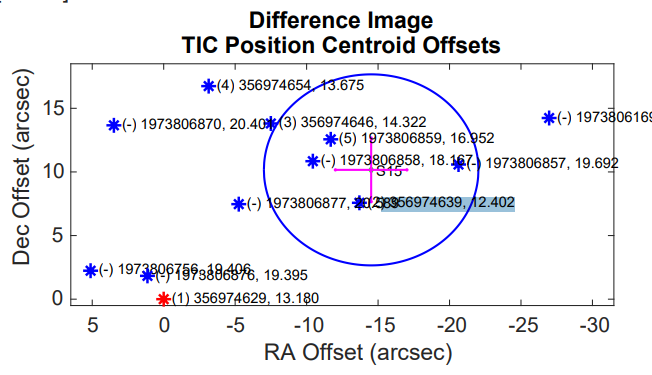

- See also: [TESS EB NEBs](https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/collections/orionlee/pht-tess-eb-nebs) collections for more examples, identified during regular Planet Hunters TESS workflow.


In [5]:
with pd.option_context('display.max_colwidth', None):
    df_to_show = df[(df["Disposition_Group"] == "FP") & (df["In TESSEBs1-26"] == "Y")][["TIC", "Disposition", "TESS EB Note", "Note", "TESSEB_URL", "Vetting_URL",]]
    display(dashboard_utils.style(df_to_show))

TIC,Disposition,TESS EB Note,Note,TESSEB_URL,Vetting_URL
356974629,FP,NEB,"The contaminat is TIC 356974639 (TESS magnitude 12.4023, 16.21 arcsec away). The matched VSX (RSCVN) is another nearby star.",details,vetting doc
458199516,FP,NEB,"contaminated, possibly by Gaia DR2 5352006133946196608. See https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/2112/1982156?comment=3270953",details,vetting doc
17342647,FP,HB,Classified as HB in VSX based on the same TESS,details,vetting doc
190693377,FP,NEB,"NEB The contaminant is TIC 190693363 (Tmag 15.364, ~26 arcsec away), a known EW type listed in [VSX]",details,vetting doc


#### False Negatives

- no discernable pattern
- see the appendix for more samples (outside the small triage samples)

In [6]:
with pd.option_context('display.max_colwidth', None):
    df_to_show = df[(df["Disposition_Group"] == "Candidate") & (df["In TESSEBs1-26"] == "N")][["TIC", "Disposition", "Type", "Note", "Vetting_URL",]]
    display(dashboard_utils.style(df_to_show))

TIC,Disposition,Type,Note,Vetting_URL
139570309,Candidate:,EA,"WIP: vet it with archival data EA + possibly additional stars. 1 - 2 additional dips in sector 7 observation, WIP",vetting doc
230024775,Candidate,EA,Tidal-induced variability with similar period and ~10% amplitude. Some flares.,vetting doc


#### Duration accuracy

- Anecdotally, duration reported in TESS EB often has visible discrepancy from observations, be it the polynomial model or 2 gaussian model.
- e.g., for TIC 272357134, the observed primary eclipse duration is ~5.8 hours (see below). In TESS EB,
  - poloynomial model gives 5.3 hours (noticeably shorter)
  - 2 gaussain model gives 9.2 hours (way too long)
- TCES, if there are matching ones, are generally more reliable.

Detrended phase Plot, with the ~5.8 hour eclipse shaded:
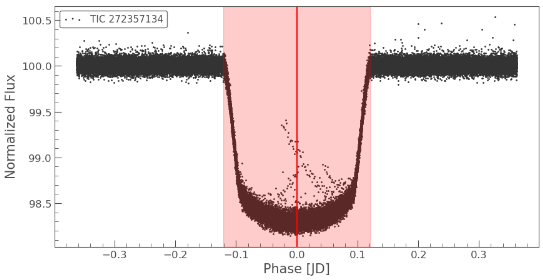

In [7]:
with pd.option_context('display.max_colwidth', None):
    df_to_show = df[(df["TESS EB Note"].str.contains("duration"))][["TIC", "Disposition", "Type", "TESS EB Note",]]
    display(dashboard_utils.style(df_to_show))

TIC,Disposition,Type,TESS EB Note
198537349,Candidate,EA,poor duration
382517745,Candidate,EA,poor duration
272357134,Candidate,EA,"duration too short for -pf (5.3h), too long for -2g (9.2h) , real: 5.8h . Missing secondary"
268404844,Candidate,EA,"duration too short for -pf (2.65h), too long for -2g (3.96h) . Real: 3.11h"


### Appendix: Sample TICs that TESS EB (probably) missed

- i.e., potential false negatives

#### Sample TICs that TESS EB missed (i.e., already classified as EB in SIMBAD, VSX or ASAS-SN)

- they are likely real miss in TESS EB, given the existing classification
- possibly worth some investigation on if there are some systematic issues leading to their misses.

In [8]:
df = df_subset
df = df[(df["TESSEB_Is_In"] != "T")]
df = df[(df["is_eb_catalog"] == "T")]

print("Num. TICs TESS EB missed (EB in SIMBAD, VSX, or ASAS-SN):", len(df))

start, end = 0, 15

# sample top TICs
df = df.sort_values(["eb_score", "tic_id"], ascending=[False, True])
display(dashboard_utils.style(df[["best_subject_img_id", ] + CAT_COLS_COMMON][start:end], show_thumbnail=True))

# sample average-ish TICs (eb_score is 3)
df = df.sort_values(["eb_score", "tic_id"], ascending=[True, True])
display(dashboard_utils.style(df[["best_subject_img_id", ] + CAT_COLS_COMMON][start:end], show_thumbnail=True))

Num. TICs TESS EB missed (EB in SIMBAD, VSX, or ASAS-SN): 269


best_subject_img_id,tic_id,best_subject_id,is_eb_catalog,eb_score,SIMBAD_MAIN_ID,SIMBAD_VAR_OTYPES,SIMBAD_Is_EB,VSX_OID,VSX_Type,VSX_Is_EB,VSX_Period,ASASSN_Name,ASASSN_URL,ASASSN_Type,ASASSN_Per,TESSEB_URL
,418292123,48933995,T,9,nan,nan,-,130438,EA|EB,T,0.754175,J034322.45+763934.3,details,EA,0.754237,details
,102069549,51633282,T,8,V* AI Phe,SB*|V*|EB*,T,26275,EA/DM,T,24.592483,J010934.19-461555.5,details,VAR,508.828831,details
,359552286,48215552,T,8,nan,nan,-,1716679,EA,T,0.625370,nan,nan,nan,nan,details
,131569323,31995019,T,7,* b Pup,El*|SB*|V*,F,26936,EB,T,1.112030,J075238.77-385143.1,details,VAR,581.442459,details
,233060434,48227121,T,7,nan,nan,-,,nan,-,nan,J175855.03+621138.4,details,EA,0.825673,details
,298666271,37754074,T,7,V* HI Dra,RR*|SB*|V*,F,13882,EW,T,0.597419,J183324.00+584222.7,details,VAR,509.238255,details
,322606029,48940412,T,7,HD 336451,SB*,-,2213632,EA,T,5.250288,nan,nan,nan,nan,details
,459915346,48940325,T,7,BD+86 130,nan,-,1546276,EA,T,8.397250,nan,nan,nan,nan,details
,20215452,46386424,T,6,nan,nan,-,630374,MISC,-,0.595757,J150916.05+360200.2,details,EA,0.595750,details
,51960132,46413812,T,6,nan,nan,-,,nan,-,nan,J005539.61+595925.9,details,EB,0.844396,details


best_subject_img_id,tic_id,best_subject_id,is_eb_catalog,eb_score,SIMBAD_MAIN_ID,SIMBAD_VAR_OTYPES,SIMBAD_Is_EB,VSX_OID,VSX_Type,VSX_Is_EB,VSX_Period,ASASSN_Name,ASASSN_URL,ASASSN_Type,ASASSN_Per,TESSEB_URL
,4735737,43266413,T,3,BD+29 2264,V*|EB*,T,44113,E:,T,nan,J121114.01+290627.0,details,ROT:,0.000000,details
,9588485,48948966,T,3,* u Her,SB*|V*|EB*,T,15899,EA/SD,T,2.051026,nan,nan,nan,nan,details
,22513851,48936710,T,3,TYC 2625-1707-1,SB*,-,2213625,EA,T,18.824290,nan,nan,nan,nan,details
,23936839,48951552,T,3,1SWASP J182416.12+351428.1,EB?|V*|EB*,T,229591,EW,T,0.275312,J182416.01+351428.3,details,EW,0.275305,details
,25776767,60848159,T,3,TYC 7167-584-1,SB*|EB*,T,2213493,EA,T,5.545580,nan,nan,nan,nan,details
,30631330,35169600,T,3,ASAS J050048-7029.8,V*|EB*,T,76832,EC,T,0.387350,J050047.90-702951.5,details,EW,0.387355,details
,31529171,35172184,T,3,UCAC4 110-010803,nan,-,633264,EW,T,0.461798,J055839.84-681145.8,details,EW,0.461790,details
,41694016,46380352,T,3,V* CV Boo,SB*|V*|EB*,T,4425,EA,T,0.846994,J152619.54+365853.5,details,EA,0.847000,details
,43791458,48935929,T,3,CRTS J174150.8+170130,EB*,T,390494,EA,T,0.460312,J174150.84+170130.8,details,EA,0.460309,details
,47629196,48941818,T,3,TYC 3531-115-1,nan,-,229619,EA,T,2.872034,J183601.84+484235.7,details,EA,2.871716,details


- no obvious pattern found yet, e.g., their VSX classifications (most of them have one) follow general trend (EA followed by EW)

In [9]:
df_vsx = df[~pd.isna(df["VSX_Type"])]
display(HTML(f"Top 5 VSX Classification for those not in TESS EB ( {len(df_vsx)} out of {len(df)} TICs with VSX classification))"))
df_vsx.groupby("VSX_Type").agg(
    num_tics=("tic_id", "count"),
).sort_values("num_tics", ascending=False).head(5)


,num_tics
VSX_Type,
EA,107
EW,48
EB,11
EC,10
EA/RS,7


#### Sample TICs that TESS EB probably missed

- they are not in SIMBAD, VSX or ASAS-SN, but have a `eb_score > 3` that indicate they are probably genuine EBs
    - so they require more vetting

In [10]:
df = df_subset
df = df[(df["TESSEB_Is_In"] != "T")]
df = df[(df["is_eb_catalog"] != "T")]


print("Num. TICs TESS EB probably missed:", len(df))

start, end = 0, 15

# sample top TICs
df = df.sort_values(["eb_score", "tic_id"], ascending=[False, True])
display(dashboard_utils.style(df[["best_subject_img_id", ] + CAT_COLS_COMMON][start:end], show_thumbnail=True))

# sample average-ish TICs (eb_score is 3)
df = df.sort_values(["eb_score", "tic_id"], ascending=[True, True])
display(dashboard_utils.style(df[["best_subject_img_id", ] + CAT_COLS_COMMON][start:end], show_thumbnail=True))


Num. TICs TESS EB probably missed: 230


best_subject_img_id,tic_id,best_subject_id,is_eb_catalog,eb_score,SIMBAD_MAIN_ID,SIMBAD_VAR_OTYPES,SIMBAD_Is_EB,VSX_OID,VSX_Type,VSX_Is_EB,VSX_Period,ASASSN_Name,ASASSN_URL,ASASSN_Type,ASASSN_Per,TESSEB_URL
,340633943,32017645,-,15,TYC 8560-2009-1,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,29658499,33285171,-,9,CD-34 6375,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,230024775,48944008,-,8,nan,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,9779230,48225299,-,7,HD 157465,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,236761861,48230988,-,7,nan,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,349055915,52578607,-,7,CD-61 1574,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,364116821,38702351,-,7,TYC 4455-633-1,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,383598522,48224493,-,7,G 169-17,SB*|V*,-,,nan,-,nan,nan,nan,nan,nan,details
,45696212,60860780,-,6,nan,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,76073981,48934888,-,6,TYC 3107-2249-1,SB*|V*,-,,nan,-,nan,nan,nan,nan,nan,details


best_subject_img_id,tic_id,best_subject_id,is_eb_catalog,eb_score,SIMBAD_MAIN_ID,SIMBAD_VAR_OTYPES,SIMBAD_Is_EB,VSX_OID,VSX_Type,VSX_Is_EB,VSX_Period,ASASSN_Name,ASASSN_URL,ASASSN_Type,ASASSN_Per,TESSEB_URL
,52357,64613852,F,3,HD 129195,V*,-,58594,VAR,-,0.377800,J144157.16-280357.6,details,L,0.000000,details
,2013258,40154642,-,3,nan,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,4207747,56365267,-,3,HD 35317,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,4918918,41023496,-,3,Wolf 327,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,8153514,41037854,-,3,BD+37 2070,RG*,-,,nan,-,nan,nan,nan,nan,nan,details
,21818238,32590361,-,3,TYC 6615-509-1,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,22877676,44572924,-,3,BD+38 2467,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,25537276,37867108,-,3,HD 221009,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,31313111,30255613,-,3,HD 40435,nan,-,,nan,-,nan,nan,nan,nan,nan,details
,32051273,36050519,-,3,CD-71 183,nan,-,,nan,-,nan,nan,nan,nan,nan,details
